In [10]:
from __future__ import print_function, division
%run basics.ipynb

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Loading BokehJS ...

In [2]:
df = pd.read_pickle('udacity_videoseq.df')
print(df.columns)
df.head(2)

Index([u'target', u'v1', u'v2'], dtype='object')


,target,v1,v2
0,1.0,"[SOUND]. Hey there, I'm Matt. One of the inst...",Let's get started with Tales from the Genome....
1,1.0,Let's get started with Tales from the Genome....,"Hey, Matt. Whatcha doin'? Oh, hey. Not much, ..."


In [11]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
all_text = df['v1'].apply(text_cleanup)
print(all_text.head(2))
v_text = vectorizer.fit_transform(all_text)
filter_w = vectorizer.get_feature_names()
_, filter_w = filter_tfidf_max(v_text, filter_w, min_th=0.05, max_th=.5)
filter_w = set(filter_w)
print('# distinct words:', len(filter_w))
print('# excluded words:', len(vectorizer.stop_words_))

0     sound hey there i m matt one of the instructo...
1     let s get started with tales from the genome ...
Name: v1, dtype: object
# distinct words: 4312
# excluded words: 15717


In [12]:
df.columns

Index([u'target', u'v1', u'v2'], dtype='object')

v1 9887
0    sound hey matt instructors tales genome excite...
1    started tales genome excited join exploration ...
Name: v1, dtype: object


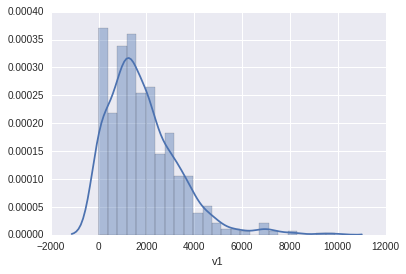

v2 9887
0    started tales genome excited join exploration ...
1    hey matt oh hey reading suppose did series den...
Name: v2, dtype: object


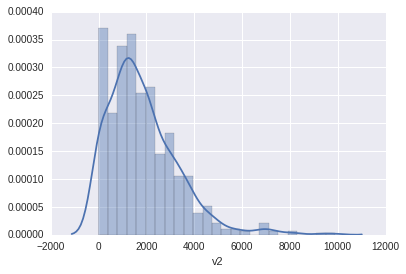

,target,v1,v2,v1_clean,v1_dig,v2_clean,v2_dig
0,1.0,"[SOUND]. Hey there, I'm Matt. One of the inst...",Let's get started with Tales from the Genome....,sound hey matt instructors tales genome excite...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1,...",started tales genome excited join exploration ...,"[12, 5, 6, 7, 168, 169, 55, 170, 22, 56, 171, ..."
1,1.0,Let's get started with Tales from the Genome....,"Hey, Matt. Whatcha doin'? Oh, hey. Not much, ...",started tales genome excited join exploration ...,"[12, 5, 6, 7, 168, 169, 55, 170, 22, 56, 171, ...",hey matt oh hey reading suppose did series den...,"[2, 3, 74, 2, 217, 565, 403, 244, 611, 217, 6,..."


In [13]:
digiz = Digitizer()
max_words = 2000

for i in ['v1', 'v2']:
    ser = df[i].copy()
    ser = ser.apply(text_cleanup, args=(filter_w, ))
    df[i + '_clean'] = ser
    print(i, ser.apply(lambda x: len(x.split())).max())
    print(ser.head(2))
    sns.distplot(ser.apply(lambda x: len(x.split())))
    plt.show()
    df[i + '_dig'] = digiz.series_digitizer(ser, max_len=max_words)
max_len = max(df[i + '_dig'].apply(len))
df.head(2)

In [14]:
n_words = digiz.num_words()
print('#words:', n_words)
print('seq len:', max_len)
df['v1_dig'].head(2)
assert all(df['v1_dig'].apply(lambda x: len(x) == max_len).tolist())

#words: 4306
seq len: 2000


In [15]:
def get_nn(n_words, input_len):   
    dim = 20
    emb = Embedding(input_dim=n_words, output_dim=dim, mask_zero=False)
    c = Input(shape=(max_len,), dtype='int32', name='v1')
    p = Input(shape=(max_len,), dtype='int32', name='v2')
    
    dropout = Dropout(0.5)
    c_emb = dropout(emb(c))
    p_emb = dropout(emb(p))
    
    maxpool = Lambda(lambda x: K.max(x, axis=1, keepdims=False),
                     output_shape=lambda x: (x[0], x[2]))
    
    c_mp = maxpool(c_emb)
    p_emb = maxpool(p_emb)
    
    c_ac = Activation('tanh')(c_mp)
    p_ac = Activation('tanh')(p_emb)
    
    #c_gru = GRU(10)(c_emb)
    #p_gru = GRU(10)(p_emb)
    
    #adder = Lambda(lambda x: (x + 1.)/2., output_shape=(max_len, dim))
    #c_emb = adder(emb(c))
    #p_emb = adder(emb(p))
    
    merge_layer = merge([c_ac, p_ac], mode='cos', dot_axes=1)    
    
    flatten_layer = Flatten()(merge_layer)
    #dense_1000 = Dense(20, activation='tanh')(merge_layer)
    #dense_100 = Dense(20, activation='relu')(dense_1000)
    #dense_1 = Dense(1, activation='sigmoid')(flatten_layer)
    
    model = Model([c, p], flatten_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
    return model

In [16]:
nn = get_nn(n_words, max_len)
print(nn.summary())
#embedded_text = nn.predict(df['digitized_text'].values.tolist())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
v1 (InputLayer)                  (None, 2000)          0                                            
____________________________________________________________________________________________________
v2 (InputLayer)                  (None, 2000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 2000, 20)      86120       v1[0][0]                         
                                                                   v2[0][0]                         
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 2000, 20)      0           embedding_1[0][0]       

In [19]:
def gen_train_valid_slit(df):
    idx = range(int(len(df)/2))
    test_idx = np.random.choice(idx, replace=False, size=len(df)/2*0.1).tolist()
    train_idx = list(set(idx) - set(test_idx))
    half_idx = int(len(df)/2)
    test_idx.extend([half_idx + i for i in test_idx])
    train_idx.extend([half_idx + i for i in train_idx])
    train_X = [np.vstack(df.iloc[train_idx]['v1_dig']), np.vstack(df['v2_dig'].iloc[train_idx])]
    train_y = df.iloc[train_idx]['target'].values
    valid_X = [np.vstack(df.iloc[test_idx]['v1_dig']), np.vstack(df['v2_dig'].iloc[test_idx])]
    valid_y = df.iloc[test_idx]['target'].values
    train_w = gen_weights(train_y)
    valid_w = gen_weights(valid_y)
    return (train_X, train_y, train_w), (valid_X, valid_y, valid_w)

(628, 2000) (628,) (628,)


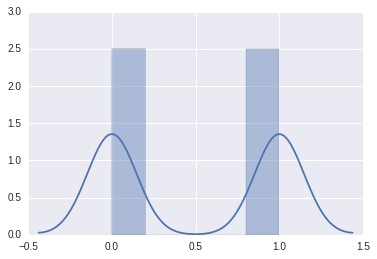

Train on 628 samples, validate on 68 samples
Epoch 1/30
628/628 [==============================] - 4s - loss: 1.3845 - mean_absolute_error: 0.5006 - val_loss: 1.8213 - val_mean_absolute_error: 0.5472
Epoch 2/30
628/628 [==============================] - 4s - loss: 0.9791 - mean_absolute_error: 0.4998 - val_loss: 1.6488 - val_mean_absolute_error: 0.5487
Epoch 3/30
628/628 [==============================] - 4s - loss: 0.8562 - mean_absolute_error: 0.4997 - val_loss: 1.5593 - val_mean_absolute_error: 0.5504
Epoch 4/30
628/628 [==============================] - 4s - loss: 0.7833 - mean_absolute_error: 0.5012 - val_loss: 1.5064 - val_mean_absolute_error: 0.5498
Epoch 5/30
628/628 [==============================] - 4s - loss: 0.7295 - mean_absolute_error: 0.5008 - val_loss: 1.4619 - val_mean_absolute_error: 0.5464
Epoch 6/30
628/628 [==============================] - 4s - loss: 0.6980 - mean_absolute_error: 0.5004 - val_loss: 1.4267 - val_mean_absolute_error: 0.5444
Epoch 7/30
628/628 [=====

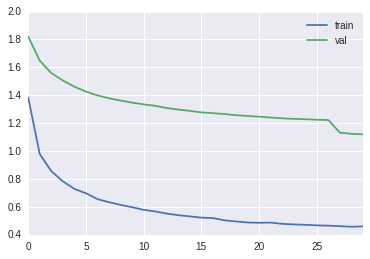

In [20]:
train, valid = gen_train_valid_slit(df)
print(train[0][0].shape, train[1].shape, train[2].shape)
sns.distplot(train[1])
plt.show()
hist = nn.fit(train[0], train[1], sample_weight=train[2],
              batch_size=32,
              validation_data=(valid[0], valid[1], valid[2]),
              shuffle=True,
              nb_epoch=30, 
              verbose=1)

plot_nn_hist(hist)

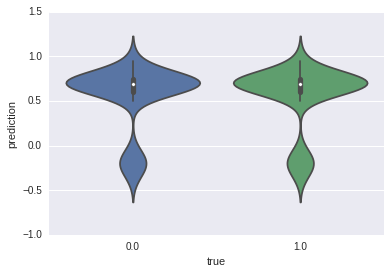

In [21]:
y_pred = nn.predict(train[0]).flatten()
plot_prediction_violins(train[1], y_pred)